## 1.	Input
1)	Load images
2)	Data preprocessing: grayscale, Gaussian filter

## 2.	Edge detection
1)	Find edge point using Canny and Probabilistic Hough Transform
2)	Setting business card boundaries
3)	Get corner points 

## 3.	Geometric mapping
1)	Sort the corner points (좌상단, 우상단, 우하단, 좌하단)
2)	Unify output image size
3)	Apply perspectiveTransform

## 4.	Image enhancement
1)	Gaussian filter
2)	Adapted Mean
3)	Morphological filter for noise reduction

## 5.	Ouput


In [10]:
# 1. Input
# a) Load images

In [11]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [12]:
# file 이름 저장
file_name_list = []
for i in range(21):
    file_name_list.append('BC'+str(i+1))
print(file_name_list)

['BC1', 'BC2', 'BC3', 'BC4', 'BC5', 'BC6', 'BC7', 'BC8', 'BC9', 'BC10', 'BC11', 'BC12', 'BC13', 'BC14', 'BC15', 'BC16', 'BC17', 'BC18', 'BC19', 'BC20', 'BC21']


In [13]:
# b) Data preprocessing: grayscale, Gaussian filter
def preprocess(img, ksize):
    # change color to gray
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    
    # Gaussian_filter
    kernel1d = cv.getGaussianKernel(ksize, ksize)
    kernel2d = np.outer(kernel1d, kernel1d.transpose())

    blur = cv.filter2D(gray, -1, kernel2d) # convolve
    return blur

In [14]:
# 2. Edge Detection

def Edge_Detection(img, original):
    # a) Find edge point

    # parameter
    r = 0.9
    t = np.pi/180
    th= 100
    mL=50
    mG=20
    
    edges = cv.Canny(img,100, 50, L2gradient = True)
    lines = cv.HoughLinesP(edges, rho=r, theta=t, threshold=th, 
                           minLineLength=mL, maxLineGap=mG)

    # b) Setting business card boundaries
    # C) Get corner points
    width, height = img.shape[:2]
    img_pts = np.array([[0,0], [width, 0], [width, height], [0, height]], np.int32)
    img_area = cv.contourArea(img_pts)
    
    max_area = -1
    max_pts = None
    
    try:
        for i in range(len(lines)):
            for j in range(i+1, len(lines)):
                # 두 직선 추출
                line1 = lines[i][0]
                line2 = lines[j][0]

                # 면을 만들기 위한 점의 좌표
                p1 = (line1[0], line1[1])
                p2 = (line1[2], line1[3])
                p3 = (line2[0], line2[1])
                p4 = (line2[2], line2[3])

                # 점의 좌표를 이용하여 면을 만들기
                pts = np.array([p1, p2, p4, p3], np.int32)
                # 면적 구하기
                area = cv.contourArea(pts)

                # 가장 큰 면적 갱신 + 잘못된 detection 제한
                if area > max_area and area < img_area/2:
                    max_area = area
                    max_pts = pts
        cv.polylines(original, [max_pts], True, (0, 0, 255), 2)

    except: # line을 찾지 못한 경우
        max_pts = img_pts
    
    return max_pts, original

In [15]:
#3. Geometric mapping
card_w = 1087
card_h = 614 
dstLR = 0
dstTB = 0
# a) Sort the corner points
def get_pts1(pts):
    # y가 작은 두 점은 상단, y가 큰 두 점은 하단
    top_pts = pts[np.argsort(pts[:, 1])][:2]
    bottom_pts = pts[np.argsort(pts[:, 1])][2:]
    
    # 상단점 중에서 x가 작은 것은 좌상단, x가 큰 것은 우상단
    tl, tr = top_pts[np.argsort(top_pts[:, 0])]

    # 하단점 중에서 x가 작은 것은 좌하단, x가 큰 것은 우하단
    bl, br = bottom_pts[np.argsort(bottom_pts[:, 0])]

    return np.float32([tl, tr, br, bl])

# b) Unify output image size
def get_pts2(pts1):
    LR1 = np.linalg.norm(pts1[0] - pts1[1])
    LR2 = np.linalg.norm(pts1[2] - pts1[3])
    TB1 = np.linalg.norm(pts1[1] - pts1[2])
    TB2 = np.linalg.norm(pts1[0] - pts1[3])
    
    distLR = LR1+LR2
    distTB = TB1+TB2
    
    if distLR > distTB: # 가로가 긴 이미지
        pts2 = np.float32([[0,0],[card_w,0],[card_w,card_h],[0,card_h]])
    else: # 세로가 긴 이미지
        pts2 = np.float32([[card_w,0],[card_w,card_h],[0,card_h], [0,0]])
    return pts2

# c) Apply perspectiveTransform
def change_geo(point, original):
    try:
        # corner point로 geometric operation 실시
        pts1 = get_pts1(point)
        pts2 = get_pts2(pts1)

        # Affine Mapping 계산
        matrix = cv.getPerspectiveTransform(pts1, pts2)

        # Affine Mapping 적용
        result = cv.warpPerspective(original, matrix, (card_w,card_h))
        return result
    except TypeError:
        return original

In [19]:
# 4. image enhancement
def remove_noise(image, kernel_size, iterations):
    # image should be binary img

    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, kernel_size)

    # remove small noise using morphological filter
    for _ in range(iterations):
        eroded = cv.erode(image, kernel, iterations)
        dilated = cv.dilate(eroded, kernel, iterations)
        image = dilated

    return image

def enhancement(img):
    block_size = 9
    C = 5
    gray = preprocess(img, 5)
    adapt = cv.adaptiveThreshold(gray, 255, cv.ADAPTIVE_THRESH_MEAN_C,
                         cv.THRESH_BINARY, block_size, C)
    result = remove_noise(adapt, (3,3),  9)
    return result

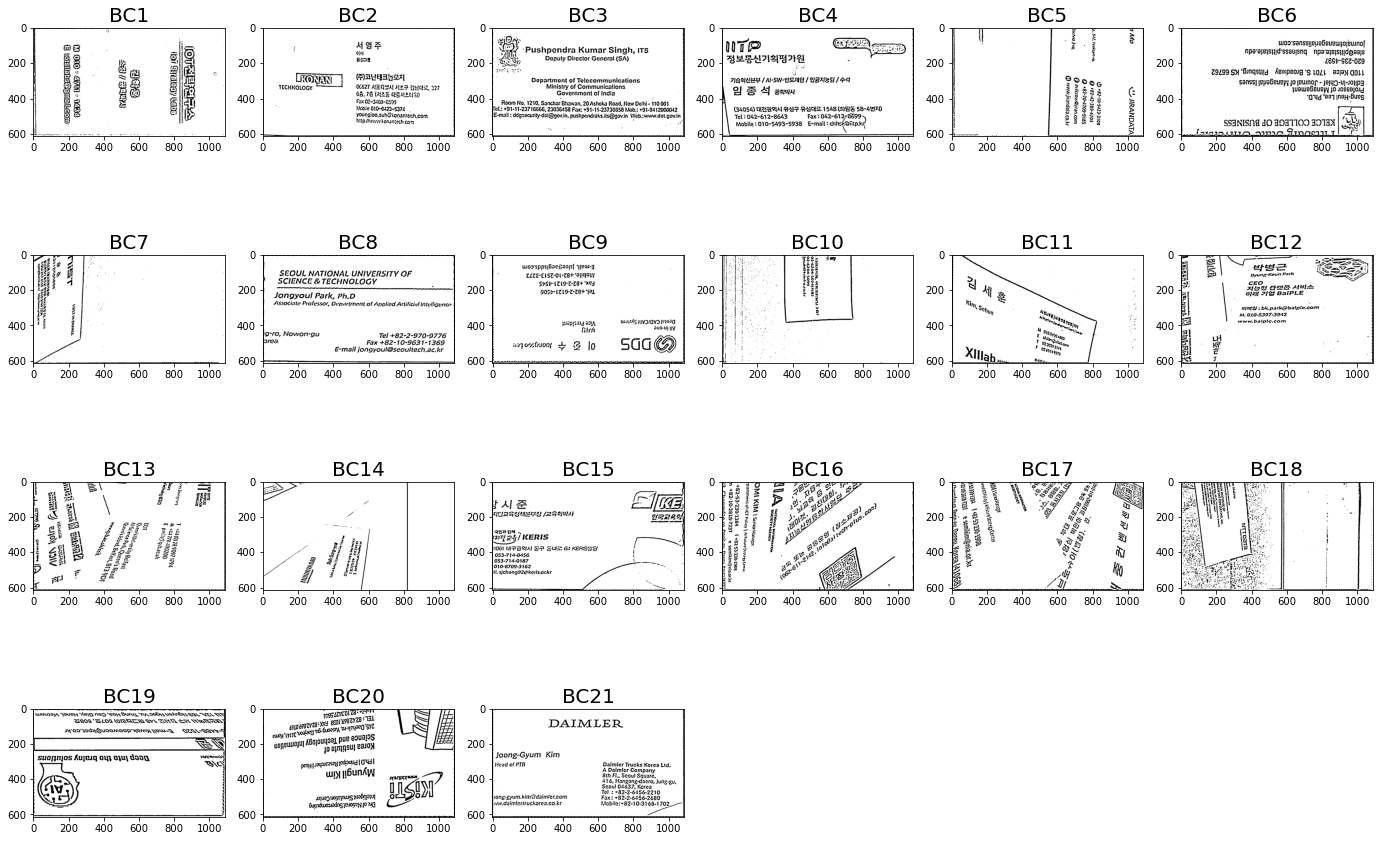

In [20]:
# main

# subplot의 행과 열 개수
row_num = 4
col_num = 6

# subplot 개수
subplot_num = 21

# subplot의 크기
subplot_size = (6,4)

# subplot 생성
fig, axes = plt.subplots(row_num, col_num, figsize=(24, 16))

# 이미지 파일 불러오기 및 subplot에 출력
for i, ax in enumerate(axes.flat):
    if i < subplot_num:
        img = cv.imread('./Data/' +file_name_list[i]+'.jpg')
        
        
        pre_img = preprocess(img, 5)
        points, edge_img = Edge_Detection(pre_img, img)
        geo_img = change_geo(points, img)
        result = enhancement(geo_img)
        
        ax.set_title(file_name_list[i], fontdict={'fontsize': 20})
        globals()['img_'+file_name_list[i]] = result
        
        ax.imshow(result, cmap='gray', vmin=0, vmax=255)
    else:
        ax.set_visible(False)

plt.show()

In [21]:
originName = "Check Img"

cv.namedWindow(originName)

cv.moveWindow(originName, 0, 30)
cv.imshow(originName, img_BC21)

cv.waitKey(0)
cv.destroyAllWindows()